# AlphaMissense Score Statistical Testing

This notebook performs statistical testing on AlphaMissense scores, similar to the dN/dS analysis in analysis.ipynb. We'll calculate p-values, q-values, and identify significantly altered genes based on AlphaMissense scores.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

## Load Gene Results with AlphaMissense Scores

First, let's load the gene results that include both expected and observed AlphaMissense scores.

In [2]:
# Load the gene results with observed DN scores
results_file = "/Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_observed_dn_scores.csv"
gene_results = pd.read_csv(results_file)
print(f"Loaded data for {len(gene_results)} genes")

# Check if we have the expected columns
required_columns = ['gene_name', 'observed_mis_am_score', 'exp_mis_scores', 'observed_dn_score', 'exp_dn_score']
missing_columns = [col for col in required_columns if col not in gene_results.columns]
if missing_columns:
    print(f"Warning: Missing required columns: {missing_columns}")
else:
    print("All required columns are present")

# Display the first few rows
gene_results[required_columns].head()

Loaded data for 15520 genes
All required columns are present


,gene_name,observed_mis_am_score,exp_mis_scores,observed_dn_score,exp_dn_score
0,KRAS,111.0805,1725.7586,112.0805,1948.7586
1,TP53,82.0906,1120.5145,107.0906,2090.5145
2,KEAP1,41.6035,2161.5357,49.6035,2969.5357
3,EGFR,39.7970,7976.3108,40.7970,10257.3108
4,STK11,19.2695,3284.3718,33.2695,3616.3718


## Define Functions for Statistical Testing

We need to define functions for likelihood ratio testing on AlphaMissense scores, similar to the selection_tester.py implementation but adapted for AlphaMissense.

In [3]:
def am_likelihood_ratio_test(observed_score, expected_score, null_model='neutral'):
    """
    Perform likelihood ratio test for AlphaMissense scores.
    
    Similar to the approach in selection_tester.py but adapted for AlphaMissense scores.
    
    Parameters:
    -----------
    observed_score: float
        Observed AM pathogenicity score
    expected_score: float
        Expected AM pathogenicity score (based on gene length, etc.)
    null_model: str
        Null model to test against ('neutral', 'positive', 'negative')
        
    Returns:
    --------
    likelihood_ratio: float
        Likelihood ratio statistic
    p_value: float
        P-value from chi-squared distribution
    """
    # Skip genes with insufficient data
    if observed_score == 0 or expected_score == 0:
        return 0.0, 1.0
    
    # Calculate the ratio of observed to expected
    obs_exp_ratio = observed_score / expected_score
    
    if null_model == 'neutral':
        # Null: ratio = 1 (neutral)
        # Alternative: ratio != 1 (selection in either direction)
        
        # Define a variance parameter for our model
        # This is estimated based on the expected value and a dispersion factor
        # We use a simplified approach here
        dispersion = 0.5  # This could be estimated from the data
        variance = expected_score * dispersion
        
        # Null model (ratio = 1)
        log_likelihood_null = stats.norm.logpdf(observed_score, expected_score, np.sqrt(variance))
        
        # Alternative model (ratio != 1)
        # We estimate the mean from observed data
        log_likelihood_alt = stats.norm.logpdf(observed_score, observed_score, np.sqrt(variance))
        
        # Likelihood ratio test
        lr = -2 * (log_likelihood_null - log_likelihood_alt)
        p_value = stats.chi2.sf(lr, df=1)  # 1 degree of freedom
        
    elif null_model == 'negative':
        # Null: ratio <= 1 (negative or neutral)
        # Alternative: ratio > 1 (positive selection)
        
        if obs_exp_ratio <= 1:
            # If obs ≤ exp, null model is best fit
            return 0.0, 1.0
        
        # For one-sided test, proceed as in the neutral case but with one-sided p-value
        dispersion = 0.5
        variance = expected_score * dispersion
        
        log_likelihood_null = stats.norm.logpdf(observed_score, expected_score, np.sqrt(variance))
        log_likelihood_alt = stats.norm.logpdf(observed_score, observed_score, np.sqrt(variance))
        
        lr = -2 * (log_likelihood_null - log_likelihood_alt)
        p_value = 0.5 * stats.chi2.sf(lr, df=1)  # One-sided test
        
    elif null_model == 'positive':
        # Null: ratio >= 1 (positive or neutral)
        # Alternative: ratio < 1 (negative selection)
        
        if obs_exp_ratio >= 1:
            # If obs ≥ exp, null model is best fit
            return 0.0, 1.0
        
        # For one-sided test in the other direction
        dispersion = 0.5
        variance = expected_score * dispersion
        
        log_likelihood_null = stats.norm.logpdf(observed_score, expected_score, np.sqrt(variance))
        log_likelihood_alt = stats.norm.logpdf(observed_score, observed_score, np.sqrt(variance))
        
        lr = -2 * (log_likelihood_null - log_likelihood_alt)
        p_value = 0.5 * stats.chi2.sf(lr, df=1)  # One-sided test
        
    else:
        raise ValueError(f"Unknown null model: {null_model}")
    
    return lr, p_value

## Apply Statistical Testing to All Genes

Now we'll apply the statistical test to all genes and calculate p-values.

In [4]:
def test_am_selection(gene_df, null_model='neutral'):
    """
    Test for selection across genes using AlphaMissense scores.
    
    Parameters:
    -----------
    gene_df: DataFrame
        DataFrame with gene results including observed and expected AM scores
    null_model: str
        Null model to test against ('neutral', 'positive', 'negative')
        
    Returns:
    --------
    DataFrame with additional test results columns
    """
    results = gene_df.copy()
    
    # Initialize columns for results
    results['am_lr'] = 0.0
    results['am_p_value'] = 1.0
    
    # First test the missense AM scores
    print("Testing missense AM scores...")
    for idx, row in results.iterrows():
        observed = row['observed_mis_am_score']
        expected = row['exp_mis_scores']
        
        if pd.notna(observed) and pd.notna(expected):
            lr, p_value = am_likelihood_ratio_test(observed, expected, null_model)
            results.loc[idx, 'am_lr'] = lr
            results.loc[idx, 'am_p_value'] = p_value
    
    # Apply multiple testing correction
    print("Applying multiple testing correction...")
    valid_pvals = ~np.isnan(results['am_p_value'])
    if sum(valid_pvals) > 0:
        _, q_values, _, _ = multipletests(
            results.loc[valid_pvals, 'am_p_value'], 
            method='fdr_bh'
        )
        results.loc[valid_pvals, 'am_q_value'] = q_values
    else:
        results['am_q_value'] = np.nan
    
    return results

# Test for all genes
print("Starting statistical testing for AlphaMissense scores...")
gene_results = test_am_selection(gene_results)
print(f"Testing complete. Added am_lr, am_p_value, and am_q_value columns.")

# Set significance threshold and add significance column
FDR_THRESHOLD = 0.1
gene_results['am_significant'] = gene_results['am_q_value'] < FDR_THRESHOLD

# Show summary of significant genes
sig_count = gene_results['am_significant'].sum()
print(f"Found {sig_count} genes with significant AlphaMissense score differences (q < {FDR_THRESHOLD})")

Starting statistical testing for AlphaMissense scores...
Testing missense AM scores...
Applying multiple testing correction...
Testing complete. Added am_lr, am_p_value, and am_q_value columns.
Found 12004 genes with significant AlphaMissense score differences (q < 0.1)
Applying multiple testing correction...
Testing complete. Added am_lr, am_p_value, and am_q_value columns.
Found 12004 genes with significant AlphaMissense score differences (q < 0.1)


## Examine Results

Let's look at genes with significant AM scores and compare with genes significant in the dN/dS analysis.

In [5]:
# Get significant genes
sig_genes = gene_results[gene_results['am_significant'] == True].sort_values('am_q_value')

# Display top significant genes
print(f"Top {min(20, len(sig_genes))} genes with significant AM score differences:")
cols_to_show = ['gene_name', 'observed_mis_am_score', 'exp_mis_scores', 'am_p_value', 'am_q_value', 'significant']
display(sig_genes[cols_to_show].head(20))

# Compare with genes significant in dN/dS analysis
if 'significant' in gene_results.columns:
    dnds_sig = gene_results[gene_results['significant'] == True]
    print(f"\nGenes significant in dN/dS analysis: {len(dnds_sig)}")
    
    # Find overlap
    overlap = set(sig_genes['gene_name']).intersection(set(dnds_sig['gene_name']))
    print(f"Genes significant in both analyses: {len(overlap)}")
    if overlap:
        print(f"Overlapping genes: {', '.join(list(overlap)[:20])}" + ("..." if len(overlap) > 20 else ""))

Top 20 genes with significant AM score differences:


,gene_name,observed_mis_am_score,exp_mis_scores,am_p_value,am_q_value,significant
0,KRAS,111.0805,1725.7586,0.0,0.0,True
10121,RNF141,0.2589,1335.0054,0.0,0.0,False
10122,RSPH4A,0.1736,2420.5672,0.0,0.0,False
10123,STAT3,0.3537,3187.4753,0.0,0.0,False
10126,AP4M1,0.2530,1347.1387,0.0,0.0,False
10128,ATAD2,0.1195,7082.4186,0.0,0.0,False
10130,UHRF1BP1,0.6766,5902.4004,0.0,0.0,False
10131,IDH3A,0.1256,2888.5490,0.0,0.0,False
10132,BNIP3L,0.9759,1522.7212,0.0,0.0,False
10117,RWDD3,0.1194,1190.4104,0.0,0.0,False



Genes significant in dN/dS analysis: 4
Genes significant in both analyses: 4
Overlapping genes: EGFR, KEAP1, TP53, KRAS


## Visualize Results

Let's create visualizations to analyze the AlphaMissense score results.

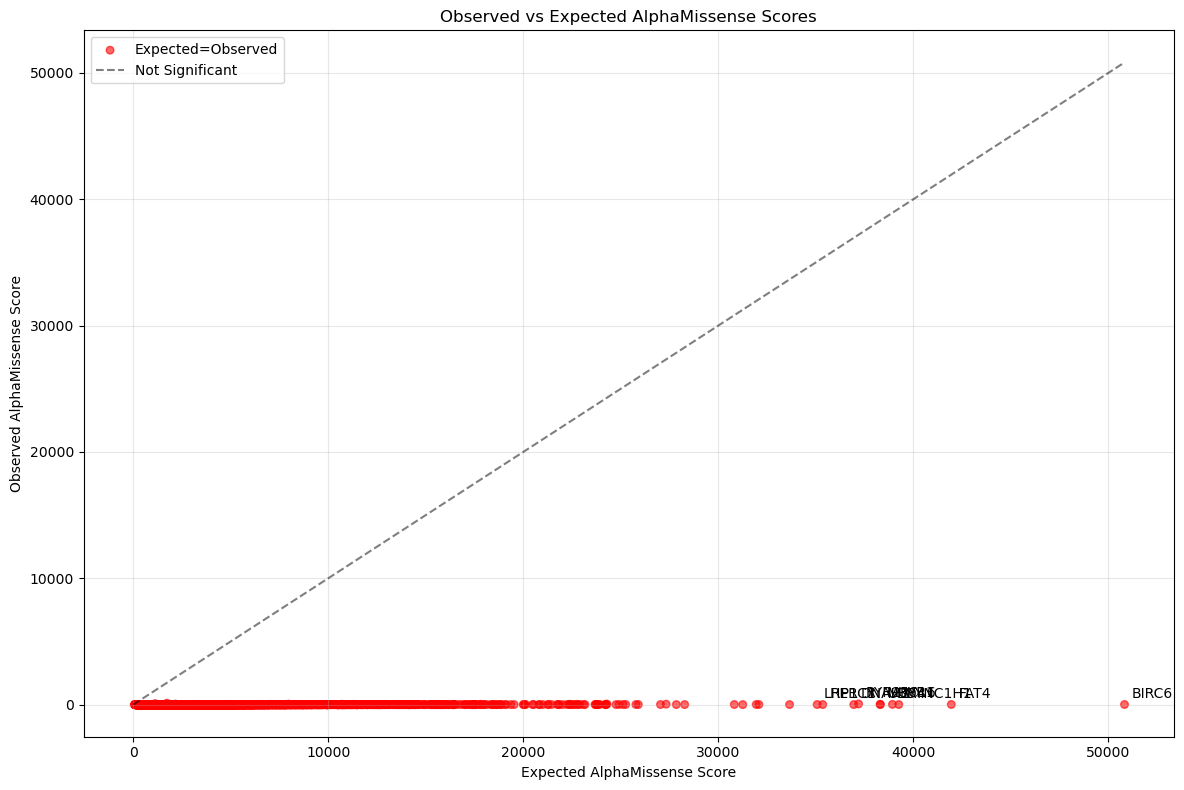

In [6]:
# Create a scatter plot of observed vs expected AM scores
plt.figure(figsize=(12, 8))

# Filter genes with at least some observed and expected scores
plot_data = gene_results[
    (gene_results['observed_mis_am_score'] > 0) & 
    (gene_results['exp_mis_scores'] > 0)
].copy()

# Add a color column based on AM significance
plot_data['color'] = plot_data['am_significant'].map({True: 'red', False: 'blue'})

# Create scatter plot
plt.scatter(
    plot_data['exp_mis_scores'], 
    plot_data['observed_mis_am_score'],
    c=plot_data['color'], 
    alpha=0.6, 
    s=30
)

# Add reference line for expected=observed
max_val = max(plot_data['exp_mis_scores'].max(), plot_data['observed_mis_am_score'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

# Add labels for top significant genes
for i, row in plot_data[plot_data['am_significant']].nlargest(10, 'am_lr').iterrows():
    plt.annotate(row['gene_name'], 
                 (row['exp_mis_scores'], row['observed_mis_am_score']),
                 xytext=(5, 5), textcoords='offset points')

# Formatting
plt.xlabel('Expected AlphaMissense Score')
plt.ylabel('Observed AlphaMissense Score')
plt.title('Observed vs Expected AlphaMissense Scores')
plt.legend(['Expected=Observed', 'Not Significant', 'Significant'])
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

## Examine Relationship Between AM Scores and dN/dS

Let's analyze the relationship between AlphaMissense significance and dN/dS significance.

Contingency Table: dN/dS vs AlphaMissense Significance


AM Significant,False,True
dN/dS Significant,,
False,3516,12000
True,0,4


Chi-square test for independence: chi2=0.24, p=0.627508


<Figure size 1000x600 with 0 Axes>

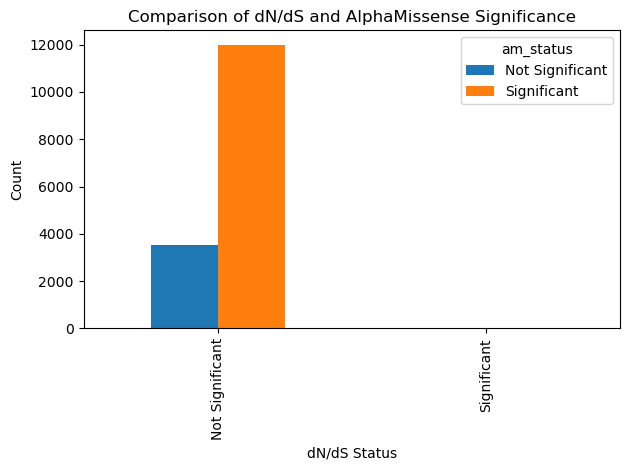

In [7]:
# Create a contingency table
if 'significant' in gene_results.columns:
    contingency = pd.crosstab(
        gene_results['significant'], 
        gene_results['am_significant'],
        rownames=['dN/dS Significant'],
        colnames=['AM Significant']
    )
    print("Contingency Table: dN/dS vs AlphaMissense Significance")
    display(contingency)
    
    # Chi-square test for independence
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    print(f"Chi-square test for independence: chi2={chi2:.2f}, p={p:.6f}")
    
    # Create a grouped bar plot
    data_for_plot = gene_results.copy()
    data_for_plot['dnds_status'] = data_for_plot['significant'].map({True: 'Significant', False: 'Not Significant'})
    data_for_plot['am_status'] = data_for_plot['am_significant'].map({True: 'Significant', False: 'Not Significant'})
    
    # Create a cross-table showing counts for p-values
    plt.figure(figsize=(10, 6))
    ct = pd.crosstab(data_for_plot['dnds_status'], data_for_plot['am_status'])
    ct.plot(kind='bar', stacked=False)
    plt.title('Comparison of dN/dS and AlphaMissense Significance')
    plt.xlabel('dN/dS Status')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Save Updated Gene Results

Finally, let's save the gene results with the new AM significance columns.

In [8]:
# Save updated results
output_file = "/Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_am_significance.csv"
gene_results.to_csv(output_file, index=False)
print(f"Saved updated gene results with AM significance to {output_file}")

# Summary of results
print("\nSummary of Results:")
print(f"- Total genes analyzed: {len(gene_results)}")
print(f"- Genes with significant AM differences: {gene_results['am_significant'].sum()}")
if 'significant' in gene_results.columns:
    print(f"- Genes with significant dN/dS: {gene_results['significant'].sum()}")
    overlap_count = ((gene_results['significant']) & (gene_results['am_significant'])).sum()
    print(f"- Genes significant in both analyses: {overlap_count}")

Saved updated gene results with AM significance to /Volumes/T7_Shield/Lab/T7_UCSD/github_repos/BENG285_team3/project_2/alphamissense/gene_results_with_am_significance.csv

Summary of Results:
- Total genes analyzed: 15520
- Genes with significant AM differences: 12004
- Genes with significant dN/dS: 4
- Genes significant in both analyses: 4
